In [38]:
! pip install -r requirements.txt --q

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from tqdm import tqdm
import osmnx as ox
import geopandas as gpd
import datetime
import gc
import sys
import json
import pandas as pd
import torch
import networkx as nx
from geopy.distance import geodesic
from datetime import datetime, timedelta

from torch_geometric.utils import from_networkx
from haversine import haversine, Unit

pd.set_option('display.max_columns', None)

In [3]:
def daynum_to_datetime(daynum):
    """
    Convert a DayNum float to a datetime object.
    
    DayNum 1 corresponds to Nov 1st, 2017, 00:00:00.
    """
    # Reference date: DayNum 1 = Nov 1st, 2017, 00:00:00
    reference_date = datetime(2017, 11, 1, 0, 0, 0)

    # Calculate the timedelta from the reference date
    delta = timedelta(days=daynum - 1)
    
    # Add the timedelta to the reference date
    result_datetime = reference_date + delta
    
    return result_datetime


## 1. Preparation

In [4]:
# Create dictionary for mapping of VehId to Vehicle_Type
df_IceHev = pd.read_excel ('VED-master\Data\VED_Static_Data_ICE&HEV.xlsx')
df_IceHev.rename(columns={'Vehicle Type': 'Vehicle_Type'}, inplace=True)
df_PhevEv = pd.read_excel ('VED-master\Data\VED_Static_Data_PHEV&EV.xlsx')
df_PhevEv.rename(columns={'EngineType': 'Vehicle_Type'}, inplace=True)
df_VehId = pd.concat([df_IceHev, df_PhevEv], ignore_index = True)
df_VehId.sort_values(by='VehId', inplace=True)
# Function to convert "NO DATA" strings to NaN values
def convert_no_data_to_nan(df, columns=None):
    if columns is None:
        columns = df.columns
    
    for col in columns:
        if df[col].dtype == 'object':  # Only apply to string columns
            df[col] = df[col].replace('NO DATA', np.nan)
    
    return df

# Apply the function to convert "NO DATA" to NaN values
df_VehId = convert_no_data_to_nan(df_VehId)
df_VehId.drop(columns=['Transmission', 'Drive Wheels'], inplace=True)
df_VehId['Generalized_Weight'] = df_VehId['Generalized_Weight'].astype('Int64')

# Drop rows with any NaN values
df_VehId.dropna(how='any', axis=0, inplace=True)
df_VehId

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_11488\235536577.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('NO DATA', np.nan)


,VehId,Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Generalized_Weight
0,2,ICE,Car,4-FI 2.0L T/C,3500
1,5,HEV,Car,4-GAS/ELECTRIC 2.0L,3500
2,7,ICE,SUV,6-FI 3.6L,4500
3,8,ICE,Car,4-FI 1.5L,2500
357,9,PHEV,Car,4-GAS/ELECTRIC 1.4L,4000
358,10,EV,Car,ELECTRIC,3500
359,11,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
4,12,ICE,Car,4-FI 1.8L,2500
360,371,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
361,379,PHEV,Car,4-GAS/ELECTRIC 1.4L,4000


In [5]:
%%time
df_list = []
input_dir = "datarepo-eved-dataset-549403600cf5/data/eVED/"
file_list = os.listdir(input_dir)
file_list = [file for file in file_list if file.endswith("_week.csv")]

for i in range(len(file_list)):
    df = pd.read_csv(input_dir + file_list[i], low_memory=False)
    print(f"Reading file ({i+1}/{len(file_list)}): {file_list[i]} (len = {len(df)})")
    df = df[df['Energy_Consumption'].notnull()]
    df_list.append(df)

raw_df = pd.concat(df_list)
print("=============================================")
print(f"Total records: {len(raw_df)}")

Reading file (1/54): eVED_171101_week.csv (len = 489414)
Reading file (2/54): eVED_171108_week.csv (len = 535198)
Reading file (3/54): eVED_171115_week.csv (len = 602092)
Reading file (4/54): eVED_171122_week.csv (len = 474329)
Reading file (5/54): eVED_171129_week.csv (len = 531856)
Reading file (6/54): eVED_171206_week.csv (len = 589154)
Reading file (7/54): eVED_171213_week.csv (len = 670084)
Reading file (8/54): eVED_171220_week.csv (len = 539468)
Reading file (9/54): eVED_171227_week.csv (len = 311927)
Reading file (10/54): eVED_180103_week.csv (len = 393498)
Reading file (11/54): eVED_180110_week.csv (len = 550780)
Reading file (12/54): eVED_180117_week.csv (len = 526771)
Reading file (13/54): eVED_180124_week.csv (len = 456757)
Reading file (14/54): eVED_180131_week.csv (len = 479522)
Reading file (15/54): eVED_180207_week.csv (len = 419846)
Reading file (16/54): eVED_180214_week.csv (len = 389642)
Reading file (17/54): eVED_180221_week.csv (len = 285924)
Reading file (18/54): e

In [6]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 308
Total unique trips: 24064


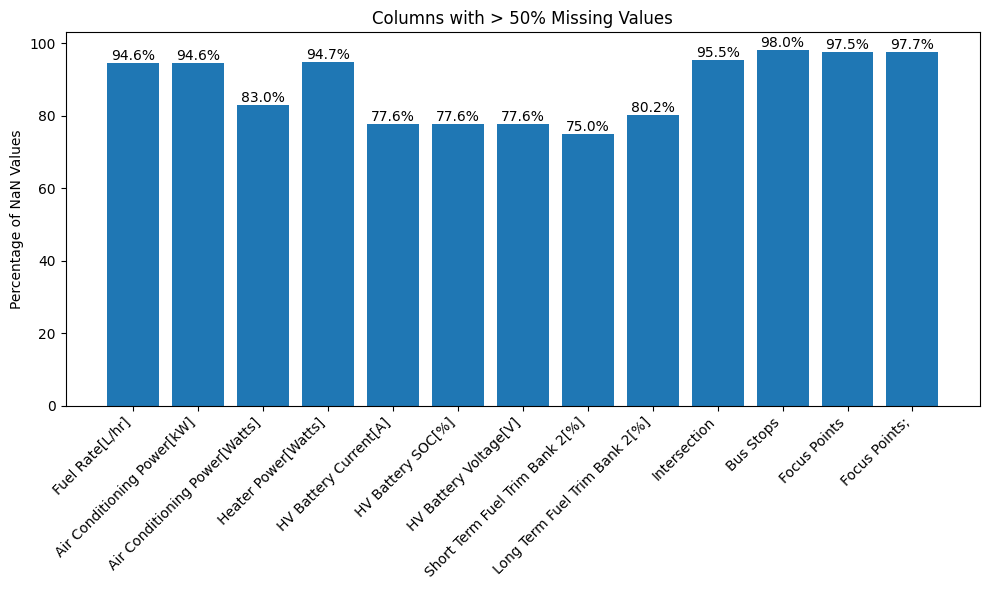

CPU times: total: 9.73 s
Wall time: 9.82 s


In [7]:
%%time
# Drop columns with >50% NaN values
nan_percentages = (raw_df.isna().sum() / len(raw_df)) * 100

# Filter columns with >80% NaN values
high_nan_cols = nan_percentages[nan_percentages > 50]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(high_nan_cols)), high_nan_cols.values)
plt.xticks(range(len(high_nan_cols)), high_nan_cols.index, rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values')  
plt.title('Columns with > 50% Missing Values')

# Add percentage labels on top of bars
for i, v in enumerate(high_nan_cols.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

raw_df.drop(columns=high_nan_cols.index, inplace=True)

              VehId          Trip         count
count  24064.000000  24064.000000  24064.000000
mean     394.988697   1444.561212    688.785032
std      146.034011    849.173767    596.433923
min        2.000000      2.000000     13.000000
25%      289.000000    902.000000    282.000000
50%      418.000000   1298.000000    540.000000
75%      522.000000   1830.000000    893.000000
max      610.000000  10896.000000  10813.000000
Trip with most data points: VehId=465.0, Trip=988.0, Count=10813.0
Trip with fewest data points: VehId=592.0, Trip=543.0, Count=13.0

Data point count distribution:
count    24064.000000
mean       688.785032
std        596.433923
min         13.000000
25%        282.000000
50%        540.000000
75%        893.000000
max      10813.000000
Name: count, dtype: float64


,VehId,Trip,count
0,592.0,543.0,13
1,269.0,1529.0,48
2,269.0,1530.0,82
3,438.0,2490.0,101
4,441.0,948.0,101
...,...,...,...
24059,492.0,2778.0,6008
24060,349.0,1555.0,6723
24061,575.0,1639.0,7095
24062,465.0,956.0,9866


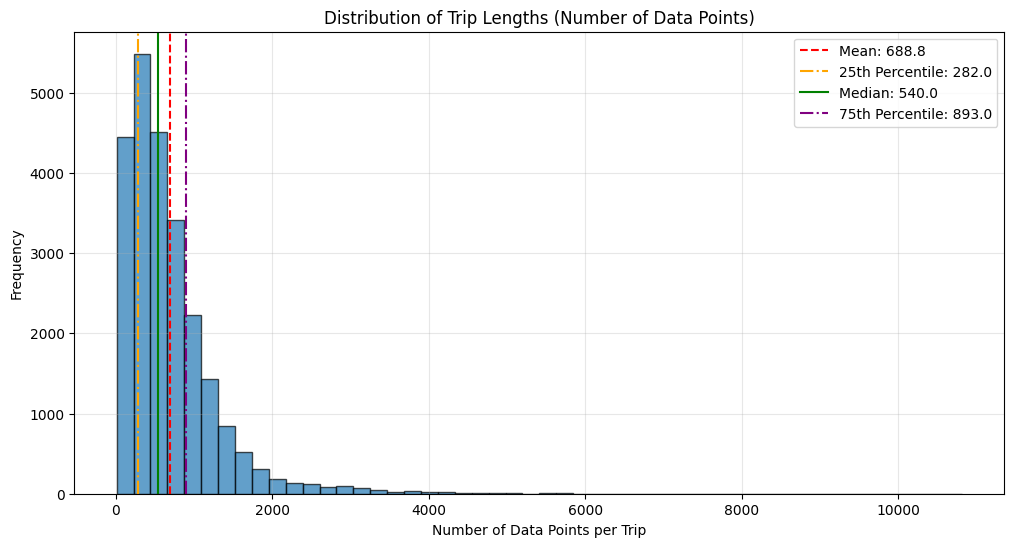

In [8]:
# Group by VehId and Trip, then count the number of rows
tracking_counts = raw_df.groupby(['VehId', 'Trip']).size().reset_index(name='count').sort_values(by='count').reset_index(drop=True)
print(tracking_counts.describe())

# Calculate percentiles for vertical lines
percentile_25 = tracking_counts['count'].quantile(0.25)
percentile_50 = tracking_counts['count'].median()
percentile_75 = tracking_counts['count'].quantile(0.75)

# Plot histogram of trip data point counts
plt.figure(figsize=(12, 6))
plt.hist(tracking_counts['count'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Trip Lengths (Number of Data Points)')
plt.xlabel('Number of Data Points per Trip')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add vertical lines for mean, median and percentiles
plt.axvline(tracking_counts['count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {tracking_counts["count"].mean():.1f}')
plt.axvline(percentile_25, color='orange', linestyle='-.', 
            label=f'25th Percentile: {percentile_25:.1f}')
plt.axvline(percentile_50, color='green', linestyle='-', 
            label=f'Median: {percentile_50:.1f}')
plt.axvline(percentile_75, color='purple', linestyle='-.', 
            label=f'75th Percentile: {percentile_75:.1f}')
plt.legend()

# Find trips with maximum and minimum data points
max_trip = tracking_counts.loc[tracking_counts['count'].idxmax()]
min_trip = tracking_counts.loc[tracking_counts['count'].idxmin()]

print(f"Trip with most data points: VehId={max_trip['VehId']}, Trip={max_trip['Trip']}, Count={max_trip['count']}")
print(f"Trip with fewest data points: VehId={min_trip['VehId']}, Trip={min_trip['Trip']}, Count={min_trip['count']}")

# Get distribution statistics
print("\nData point count distribution:")
print(tracking_counts['count'].describe())

tracking_counts

In [9]:
class Node:
    def __init__(self, lat, lon, raw_lat, raw_lon, ele):
        self.lat = lat
        self.lon = lon
        self.raw_lat = raw_lat
        self.raw_lon = raw_lon
        self.ele = ele  

    def __str__(self):
        return f"""Node({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Edge:
    def __init__(self, df):
        start_row = df.sort_values('Timestamp(ms)').iloc[0]
        self.start_date = daynum_to_datetime(start_row['DayNum'])
        self.start_node = Node(
            lat     = start_row['Matchted Latitude[deg]'], 
            lon     = start_row['Matched Longitude[deg]'], 
            raw_lat = start_row['Latitude[deg]'],
            raw_lon = start_row['Longitude[deg]'],
            ele     = start_row['Elevation Smoothed[m]']
            )

        end_row = df.sort_values('Timestamp(ms)').iloc[-1]
        self.end_date = daynum_to_datetime(end_row['DayNum'])
        self.end_node = Node(
            lat     = end_row['Matchted Latitude[deg]'], 
            lon     = end_row['Matched Longitude[deg]'], 
            raw_lat = end_row['Latitude[deg]'],
            raw_lon = end_row['Longitude[deg]'],
            ele     = end_row['Elevation Smoothed[m]'])      

        self.distance = haversine((self.start_node.lat, self.start_node.lon), (self.end_node.lat, self.end_node.lon), unit=Unit.METERS)
        self.time = (end_row['Timestamp(ms)'] - start_row['Timestamp(ms)']) / 1000  # Convert milliseconds to seconds

        self.speed              = float(df['Vehicle Speed[km/h]'].mean())
        self.maf                = float(df['MAF[g/sec]'].mean())
        self.engine_rpm         = float(df['Engine RPM[RPM]'].mean())
        self.absolute_load      = float(df['Absolute Load[%]'].mean())
        self.oat                = float(df['OAT[DegC]'].mean())
        self.stft_bank1         = float(df['Short Term Fuel Trim Bank 1[%]'].mean())
        self.ltft_bank1         = float(df['Long Term Fuel Trim Bank 1[%]'].mean())
        self.gradient           = float(df['Gradient'].mean())
        # self.speed_limit        = float(df['Speed Limit[km/h]'].astype('Int64').mean())
        self.energy_consumption = float(df['Energy_Consumption'].mean())

    def __str__(self):
        return f"""Edge({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Trip:
    def __init__(self, trip_df, data=None):
        self.vehicle_id = trip_df['VehId'].values[0]
        self.trip_id = str(trip_df['Trip'].values[0]) + "_" + str(trip_df['VehId'].values[0])

        self.start_date = daynum_to_datetime(min(trip_df['DayNum']))
        self.running_time = max(trip_df['Timestamp(ms)']) / 1000
        self.end_date = self.start_date + timedelta(seconds=self.running_time)
        # self.vehicle_type = trip_df['Vehicle_Type'].values[0]
        # self.weight = trip_df['Generalized_Weight'].values[0]
        # self.engine = trip_df['Engine Configuration & Displacement'].values[0]
        
        self.edge_list = []
        sorted_trip_df = trip_df.sort_values('Timestamp(ms)').reset_index(drop=True)
        
        for i in range(len(sorted_trip_df) - 1):
            # Create a segment dataframe with current and next point
            segment_df = sorted_trip_df.iloc[i:i+2]
            self.edge_list.append(Edge(segment_df))
        
        self.node_list = [edge.start_node for edge in self.edge_list] + [self.edge_list[-1].end_node]

    def visualize_trip(self, zoom=14, save_path=None):
        # Create a map centered on the mean latitude and longitude of the trip
        
        center_lat = pd.Series([node.lat for node in self.node_list]).mean()
        center_lon = pd.Series([node.lon for node in self.node_list]).mean()
        trip_map = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

        folium.PolyLine(
            [[node.raw_lat, node.raw_lon] for node in self.node_list],
            color='#ADD8E6',
            weight=5,
            opacity=0.7,
            tooltip='raw GPS route'
        ).add_to(trip_map)

        # Add a polyline to show the trip route
        folium.PolyLine(
            [[node.lat, node.lon] for node in self.node_list],
            color='blue',
            weight=3,
            opacity=0.9,
            tooltip='Trip route'
        ).add_to(trip_map)
        
        folium.Marker(
            location=[self.node_list[0].lat, self.node_list[0].lon],
            popup='Start',
            icon=folium.Icon(color='green', icon='play')
        ).add_to(trip_map)

        folium.Marker(
            location=[self.node_list[-1].lat, self.node_list[-1].lon],
            popup='End',
            icon=folium.Icon(color='red', icon='stop')
        ).add_to(trip_map)
        
        return trip_map

    def __str__(self):
        return f"""Trip({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

In [10]:
short_trip = Trip(raw_df[(raw_df['VehId'] == 592) & (raw_df['Trip'] == 543)])
short_trip.visualize_trip(zoom=20)

In [11]:
medium_tracking_counts = tracking_counts.iloc[int(len(tracking_counts)/2)]
medium_trip = Trip(raw_df[(raw_df['VehId'] == medium_tracking_counts['VehId']) & (raw_df['Trip'] == medium_tracking_counts['Trip'])])
medium_trip.visualize_trip(zoom=15)

In [12]:
medium_tracking_counts = tracking_counts.iloc[int(len(tracking_counts)/2) - 1]
medium_trip = Trip(raw_df[(raw_df['VehId'] == medium_tracking_counts['VehId']) & (raw_df['Trip'] == medium_tracking_counts['Trip'])])
medium_trip.visualize_trip(zoom=15)

In [13]:
long_trip  = Trip(raw_df[(raw_df['VehId'] == 465) & (raw_df['Trip'] == 988)])
long_trip.visualize_trip()

In [14]:
percentile_25 = float(tracking_counts['count'].quantile(0.25))
percentile_50 = float(tracking_counts['count'].median())
percentile_75 = float(tracking_counts['count'].quantile(0.75))

raw_df = raw_df.merge(tracking_counts, on=['VehId', 'Trip'], how='left')
raw_df = raw_df[(raw_df['count'] > percentile_25) & (raw_df['count'] < percentile_75)]
raw_df.drop(columns=['count'], inplace=True)
print("Dataframe size:", raw_df.shape)
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Dataframe size: (6651945, 23)
Total unique vehicles: 299
Total unique trips: 12021


In [15]:
raw_df = raw_df.merge(df_VehId, on='VehId', how='inner')

In [ ]:
# Calculate percentage of null values for each column
null_percentages = (raw_df.isnull().sum() / len(raw_df)) * 100

# Sort from highest to lowest null percentage
sorted_null_percentages = null_percentages.sort_values(ascending=False)

# Display columns with their null percentages
print("Null percentage by column:")
for col, pct in sorted_null_percentages.items():
    if pct > 0:  # Only show columns that have null values
        print(f"{col}: {pct:.2f}%")
        
raw_df.drop(columns=['Latitude[deg]', 'Longitude[deg]', 'Absolute Load[%]', 'Long Term Fuel Trim Bank 1[%]', 'Short Term Fuel Trim Bank 1[%]', 'MAF[g/sec]', 'Vehicle Class', 'Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]'], inplace=True)
raw_df.dropna(how='any', axis=0)
raw_df.reset_index(drop=True, inplace=True)

Null percentage by column:
Absolute Load[%]: 93.54%
Long Term Fuel Trim Bank 1[%]: 93.54%
Short Term Fuel Trim Bank 1[%]: 73.14%
MAF[g/sec]: 39.57%
Engine RPM[RPM]: 11.82%
OAT[DegC]: 5.88%
Gradient: 1.63%
Class of Speed Limit: 1.31%
Speed Limit[km/h]: 1.31%
Speed Limit with Direction[km/h]: 1.31%
Total unique vehicles: 32
Total unique trips: 1836


In [24]:
raw_df['VehId'] = raw_df['VehId'].astype('Int64')
raw_df['Trip']  = raw_df['Trip'].astype('Int64')
raw_df['Timestamp(ms)'] = raw_df['Timestamp(ms)'].astype('Int64')
raw_df['Engine RPM[RPM]'] = raw_df['Engine RPM[RPM]'].astype('Int64')
raw_df.to_csv("DATA/raw_data.csv", index=False)

In [25]:
# Get initial memory info
before = len(gc.get_objects())
print(f"Objects before: {before}")
# Clear large dataframes and lists
del df_list
del raw_df
del df_IceHev
del df_PhevEv
del df_VehId
del df
del high_nan_cols
del nan_percentages

# Force garbage collection
gc.collect()

# Get memory info after cleanup
after = len(gc.get_objects())
print(f"Objects after: {after}")

Objects before: 643095
Objects after: 634421


## 2. Preprocessing

In [67]:
full_df = pd.read_csv("DATA/raw_data.csv", low_memory=False)

print("Total unique vehicles:", full_df['VehId'].nunique())
print("Total unique trips:",    full_df[['VehId','Trip']].drop_duplicates().shape[0])

full_df.rename(columns={'Matchted Latitude[deg]': 'Matched Latitude[deg]'}, inplace=True)
full_df.drop(columns=['Latitude[deg]', 'Longitude[deg]'], inplace=True)
print(full_df.columns)
full_df

Total unique vehicles: 32
Total unique trips: 1836
Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Vehicle Speed[km/h]',
       'Engine RPM[RPM]', 'OAT[DegC]', 'Elevation Smoothed[m]', 'Gradient',
       'Energy_Consumption', 'Matched Latitude[deg]', 'Matched Longitude[deg]',
       'Speed Limit[km/h]', 'Vehicle_Type',
       'Engine Configuration & Displacement', 'Generalized_Weight'],
      dtype='object')


,DayNum,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Elevation Smoothed[m],Gradient,Energy_Consumption,Matched Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,1.058991,11,1485,0,40.439999,1336.0,6.25,258.927948,0.000000,0.002591,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
1,1.058991,11,1485,200,40.439999,2214.0,6.25,258.927948,0.000000,0.002591,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
2,1.058991,11,1485,300,40.439999,2214.0,6.25,258.927948,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
3,1.058991,11,1485,600,42.599998,2214.0,6.25,258.927948,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
4,1.058991,11,1485,1600,43.459999,2214.0,6.25,258.927948,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065496,374.535685,388,2183,597000,23.160000,0.0,5.25,250.538107,0.017723,0.007182,42.279631,-83.750286,56,PHEV,4-GAS/ELECTRIC 2.0L,4000
1065497,374.535685,388,2183,598000,23.840000,0.0,5.25,250.889444,0.000000,0.001940,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000
1065498,374.535685,388,2183,599000,19.910000,0.0,5.25,251.240781,0.000000,0.000371,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000
1065499,374.535685,388,2183,599800,19.910000,0.0,5.25,251.592117,0.000000,0.000370,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000


In [ ]:
mean_elevation = full_df.groupby(['Matched Latitude[deg]','Matched Longitude[deg]'])['Elevation Smoothed[m]'].mean().reset_index()
full_df = full_df.merge(mean_elevation, on=['Matched Latitude[deg]','Matched Longitude[deg]'], how='left', suffixes=('', '_mean'))
full_df.drop(columns=['Elevation Smoothed[m]'], inplace=True)
full_df.rename(columns={'Elevation Smoothed[m]_mean': 'Elevation Smoothed[m]'}, inplace=True)
full_df

,DayNum,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Gradient,Energy_Consumption,Matched Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight,Elevation Smoothed[m]
0,1.058991,11,1485,0,40.439999,1336.0,6.25,0.000000,0.002591,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
1,1.058991,11,1485,200,40.439999,2214.0,6.25,0.000000,0.002591,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
2,1.058991,11,1485,300,40.439999,2214.0,6.25,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
3,1.058991,11,1485,600,42.599998,2214.0,6.25,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
4,1.058991,11,1485,1600,43.459999,2214.0,6.25,0.000000,-0.004696,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065496,374.535685,388,2183,597000,23.160000,0.0,5.25,0.017723,0.007182,42.279631,-83.750286,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,249.921609
1065497,374.535685,388,2183,598000,23.840000,0.0,5.25,0.000000,0.001940,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,251.328615
1065498,374.535685,388,2183,599000,19.910000,0.0,5.25,0.000000,0.000371,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,251.328615
1065499,374.535685,388,2183,599800,19.910000,0.0,5.25,0.000000,0.000370,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,251.328615


In [66]:
full_df.head()

,DayNum,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Gradient,Energy_Consumption,Matched Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight,Elevation Smoothed[m]
0,1.058991,11,1485,0,40.439999,1336.0,6.25,0.0,0.002591,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
1,1.058991,11,1485,200,40.439999,2214.0,6.25,0.0,0.002591,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
2,1.058991,11,1485,300,40.439999,2214.0,6.25,0.0,-0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
3,1.058991,11,1485,600,42.599998,2214.0,6.25,0.0,-0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839
4,1.058991,11,1485,1600,43.459999,2214.0,6.25,0.0,-0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,258.164839


In [ ]:
%%time
# 15mins
G = nx.DiGraph()

# Iterate through trips to add nodes and edges
for (veh_id, trip), trip_df in tqdm(full_df.groupby(['VehId', 'Trip'])):
    trip_df = trip_df.reset_index(drop=True)

    for i in range(len(trip_df) - 1):
        current = trip_df.loc[i]
        next_point = trip_df.loc[i + 1]
        # Skip if the next point is NaN                 
        # Node definitions (latitude, longitude)
        curr_node = (current['Matchted Latitude[deg]'], current['Matched Longitude[deg]'])
        next_node = (next_point['Matchted Latitude[deg]'], next_point['Matched Longitude[deg]'])

        # Add node attributes
        if curr_node not in G:
            G.add_node(curr_node,
                    latitude=current['Matchted Latitude[deg]'],
                    longitude=current['Matched Longitude[deg]'],
                    elevation=current['Elevation Smoothed[m]'])

        if next_node not in G:
            G.add_node(next_node,
                    latitude=next_point['Matchted Latitude[deg]'],
                    longitude=next_point['Matched Longitude[deg]'],
                    elevation=next_point['Elevation Smoothed[m]'])

        # Compute distance
        distance = haversine(curr_node, next_node, unit=Unit.METERS)

        # Edge attributes
        G.add_edge(curr_node, 
                next_node,
                distance=distance,
                gradient=next_point['Gradient'],
                energy_consumption=next_point['Energy_Consumption'],
                vehicle_speed=next_point['Vehicle Speed[km/h]'],
                temperature=next_point['OAT[DegC]'],
                engine_rpm=next_point['Engine RPM[RPM]'],
                absolute_load=next_point['Absolute Load[%]'])


In [ ]:
# Convert to PyTorch Geometric format (automatically handles indexing)
pyg_data = from_networkx(G)

# Example of normalization (optional but recommended)
# Normalize Node Elevation
elevation = torch.tensor([attr['elevation'] for _, attr in G.nodes(data=True)], dtype=torch.float32)
elev_mean, elev_std = elevation.mean(), elevation.std()
pyg_data.x = ((elevation - elev_mean) / elev_std).unsqueeze(1)  # Node features in PyG (N, 1)

# Normalize Edge attributes
edge_attrs = ['distance', 'gradient', 'energy_consumption', 'vehicle_speed',
            'temperature', 'engine_rpm', 'absolute_load']

edge_features = []
for attr in edge_attrs:
    vals = torch.tensor([G[u][v][attr] for u, v in G.edges()], dtype=torch.float32)
    mean, std = vals.mean(), vals.std()
    normalized = (vals - mean) / std
    edge_features.append(normalized.unsqueeze(1))

# Concatenate edge features
pyg_data.edge_attr = torch.cat(edge_features, dim=1)

# Check resulting PyG data
print(pyg_data)
print("Node feature shape:", pyg_data.x.shape)
print("Edge feature shape:", pyg_data.edge_attr.shape)
